In [4]:
# Install necessary requirements
# !pip install matplotlib
# !pip install pandas
# !pip install pillow
# !pip install scipy
# !pip install keras


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random
import numpy as np
import cv2
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, Model
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

target_shape = (245,200)

Check if TPU is available

In [6]:
# Check if a TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU detected and initialized.")
except ValueError:
    # No TPU found, specify GPU or CPU here
    use_gpu = True  # Set this to True to use GPU or False to use CPU
    if use_gpu and tf.config.list_physical_devices("GPU"):
        strategy = tf.distribute.MirroredStrategy()  # Use GPU
        print("Using GPU for TensorFlow computations.")
    else:
        strategy = tf.distribute.get_strategy()  # Use CPU
        print("Using CPU for TensorFlow computations.")

# Now you can define and run your TensorFlow model using the selected strategy

Using CPU for TensorFlow computations.


In [7]:
def show_img(path):
    image_path = path
    img = mpimg.imread(image_path)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()

def read_csv_to_df(path):
    file_path =  path

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    return df

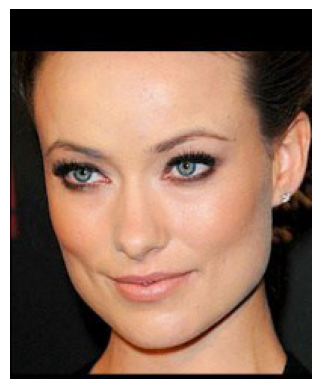

In [8]:
show_img('dataset/train/left/abn.jpg')
train_pairing_df = read_csv_to_df('dataset/train.csv')

1.  Load Training data and augment it
2.  Load Testing data

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to [0, 1]
    rotation_range=0,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift image width by up to 20%
    height_shift_range=0.2, # Randomly shift image height by up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Randomly zoom in on images by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill mode for newly created pixels
)

test_datagen = ImageDataGenerator(
    rescale=1./255)

# Set the batch size and image size
batch_size = 32
image_size = (245,200)



Now Pair up the left and right images with labels 
1. 1 means similar images 
2. 0 means dissimilar images

In [10]:
def load_and_preprocess_image(image_path, target_size=(245, 200), random_transform=False):
    # Open the image using Pillow (PIL)
    img = load_img(image_path, target_size = target_size)
    img = img_to_array(img,dtype='int32')

    if random_transform:
        img = train_datagen.random_transform(img)

    
    return img

def create_train_valid_dataset(random_transform, num_dissimilar_pairs = train_pairing_df.size):
    # Create lists to store paired left and right images
    image_pairs_with_label = []

    # Iterate through the rows of the CSV file and load/preprocess the images
    for index, row in train_pairing_df.iterrows():
        # load and pair the similar image first
        left_image = load_and_preprocess_image(f"dataset/train/left/{row['left']}.jpg", random_transform = random_transform)
        right_image = load_and_preprocess_image(f"dataset/train/right/{row['right']}.jpg",random_transform = random_transform)
        image_pair_with_label = [[left_image,right_image],1.0]
        image_pairs_with_label.append(image_pair_with_label)
    
    num_dissimilar_pairs = num_dissimilar_pairs  # You may adjust this number
    for _ in range(num_dissimilar_pairs):
        left_idx = random.randint(0, len(train_pairing_df) - 1)
        right_idx = random.randint(0, len(train_pairing_df) - 1)

        # Ensure left and right images are not the same
        while left_idx == right_idx:
            right_idx = random.randint(0, len(train_pairing_df) - 1)

        left_image = load_and_preprocess_image(f"dataset/train/left/{train_pairing_df.iloc[left_idx]['left']}.jpg", random_transform=random_transform)
        right_image = load_and_preprocess_image(f"dataset/train/right/{train_pairing_df.iloc[right_idx]['right']}.jpg", random_transform=random_transform)
        image_pair_with_label = [[left_image, right_image], 0.0]  # Label 0 for dissimilar pair
        image_pairs_with_label.append(image_pair_with_label)

    # Shuffle the list to mix similar and dissimilar pairs
    random.shuffle(image_pairs_with_label)

    return image_pairs_with_label

def display_image_pairs(image_pairs, num_pairs_to_display=5):
    plt.figure(figsize=(12, 6))

    for i in range(num_pairs_to_display):
        left_image = image_pairs[i][0][0]
        right_image = image_pairs[i][0][1]
        label = image_pairs[i][1]

        # Choose a title based on similarity label
        if label == 1:
            title = "Similar Pair"
        else:
            title = "Dissimilar Pair"

        # Display the left image
        plt.subplot(2, num_pairs_to_display, i + 1)
        plt.imshow(left_image)
        plt.title(title)
        plt.axis("off")

        # Display the right image
        plt.subplot(2, num_pairs_to_display, num_pairs_to_display + i + 1)
        plt.imshow(right_image)
        plt.title(f"Label: {label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Now to show what pairs of images look like

In [11]:
train_valid_dataset = create_train_valid_dataset(True)

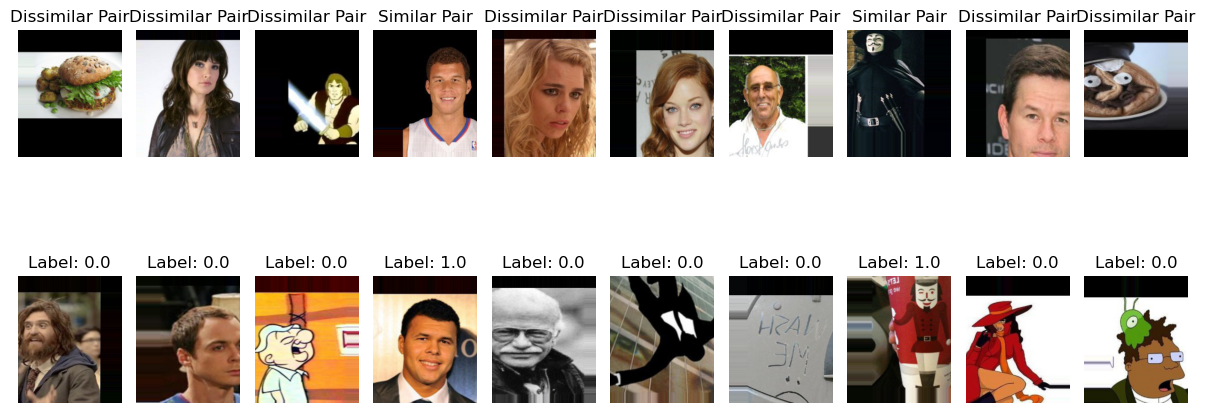

In [ ]:
display_image_pairs(train_valid_dataset,10)

Now extract features using libraries. Such as local features

In [ ]:
def show_local_features(detector, image):
    img = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2BGR)

    key_points, description = detector.detectAndCompute(img, None)
    img_keypoints = cv2.drawKeypoints(img, 
                                            key_points, 
                                            img, 
                                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw circles.
    rgb = cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.title('detector Interest Points')
    plt.imshow(rgb); plt.show()

def image_detect_and_compute(detector, img_name):
    """Detect and compute interest points and their descriptors."""
    img = cv2.cvtColor(img_name.astype(np.uint8), cv2.COLOR_RGB2BGR)
    kp, des = detector.detectAndCompute(img, None)
    return img, kp, des
    

def draw_image_matches(detector, image_pair, distance_threshold = 0.75):
    """Draw ORB feature matches of the given two images."""

    img1, kp1, des1 = image_detect_and_compute(detector, image_pair[0])
    img2, kp2, des2 = image_detect_and_compute(detector, image_pair[1])
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < distance_threshold*n.distance:
            good.append([m])
    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb),plt.show()
    




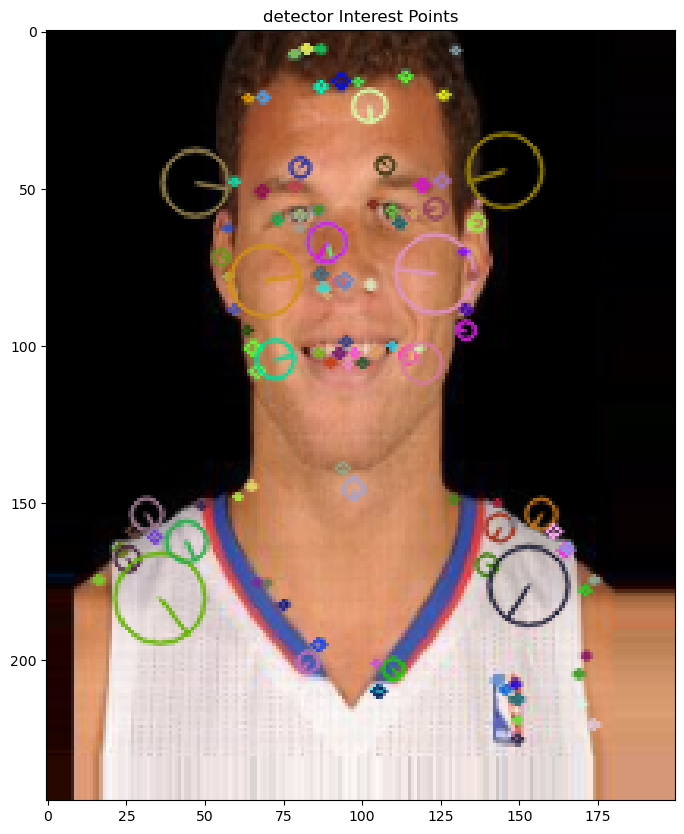

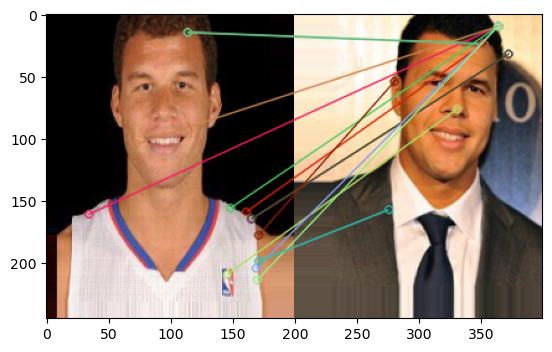

In [ ]:
orb = cv2.ORB_create()
sift = cv2.SIFT_create()

show_local_features(sift,train_valid_dataset[5][0][0])
draw_image_matches(sift, train_valid_dataset[5][0])


Extract features from pretrained model like ResNet 

In [ ]:
def extract_resnet50_features(x):
    # Load the ResNet50 model pre-trained on ImageNet data
    model = ResNet50(weights='imagenet', include_top=False, input_shape=target_shape)
    
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract features from the image
    features = model.predict(x)

    return features

def visualize_feature_maps(features, number_of_feature_to_show=10, figsize=(10, 10), cmap='viridis'):
    num_features = features.shape[-1]
    num_rows = (num_features + 4) // 5  # Calculate the number of rows needed

    plt.figure(figsize=figsize)
    for i in range(number_of_feature_to_show):
        if i < num_features:
            plt.subplot(num_rows, 5, i + 1)
            feature_map = features[0, :, :, i]

            # Resize the feature map for better visualization
            resized_feature_map = cv2.resize(feature_map, (200, 200))
            plt.imshow(resized_feature_map, cmap=cmap, interpolation='nearest')
            plt.axis('off')
            plt.title(f'Feature {i + 1}')

    plt.suptitle(f'Feature Maps Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()


def measure_feature_distance(left_img, right_img):
    feature_map_l1 = extract_resnet50_features(left_img)
    feature_map_r1 = extract_resnet50_features(right_img)
    feature_vector_l1 = feature_map_l1.flatten()
    feature_vector_r1 = feature_map_r1.flatten()
    # Compute the dot product
    similarity = np.dot(feature_vector_l1, feature_vector_r1)
    return similarity




In [ ]:
def create_siamese_with_resnet(input_shape):
    # Load a pre-trained ResNet model
    base_cnn = ResNet50(
        weights="imagenet",
        input_shape=input_shape,
        include_top=False,
    )

    # Freeze the layers of the pre-trained ResNet
    for layer in base_cnn.layers:
        layer.trainable = False

    # Extract features using the ResNet model
    input_image = tf.keras.layers.Input(shape=input_shape)
    features = base_cnn(input_image)

    # Define the Siamese network on top of the extracted features
    flatten = layers.Flatten()(features)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    embedding = models.Model(input_image, output, name="Embedding")

    # Define the Siamese network
    input_left = tf.keras.layers.Input(shape=input_shape, name="left_input")
    input_right = tf.keras.layers.Input(shape=input_shape, name="right_input")
    output_left = embedding(input_left)
    output_right = embedding(input_right)

    # Calculate similarity score (e.g., cosine similarity)
    similarity_score = layers.Dot(axes=-1, normalize=True)([output_left, output_right])

    siamese_model = models.Model(inputs=[input_left, input_right], outputs=similarity_score)

    return siamese_model


def contrastive_loss(y_true, y_pred):
    margin = 1.0  # You can adjust the margin as needed
    return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0)))

In [ ]:
# Define the input shape
input_shape = (245, 200, 3)

# Create the Siamese network
siamese_model = create_siamese_with_resnet(input_shape)

# Compile the model
siamese_model.compile(loss=contrastive_loss, optimizer='adam', metrics=['accuracy'])

# Split the dataset into training and validation sets (e.g., 80% for training, 20% for validation)
train_pairs, valid_pairs = train_test_split(train_valid_dataset, test_size=0.2, random_state=42)


In [ ]:
# Prepare the training and validation data
train_left_images = np.array([pair[0][0] for pair in train_pairs])
train_right_images = np.array([pair[0][1] for pair in train_pairs])
train_labels = np.array([pair[1] for pair in train_pairs])

valid_left_images = np.array([pair[0][0] for pair in valid_pairs])
valid_right_images = np.array([pair[0][1] for pair in valid_pairs])
valid_labels = np.array([pair[1] for pair in valid_pairs])


In [ ]:
train_labels

array([1., 0., 1., ..., 1., 0., 1.])

In [ ]:
num_epochs = 10  # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed

history = siamese_model.fit(
    [train_left_images, train_right_images],
    train_labels,
    validation_data=([valid_left_images, valid_right_images], valid_labels),
    epochs=num_epochs,
    batch_size=batch_size
)

MemoryError: Unable to allocate 2.63 GiB for an array with shape (4800, 245, 200, 3) and data type int32